# Import

In [35]:
from pathlib import Path
from torch.utils.data import DataLoader
import torch
from collections import OrderedDict
import numpy as np

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import functions
from tutorials.unet_model import construct_unet
import os

---
# Utility Functions

In [ ]:
def load_dataset(root, channeled=True):
    if not channeled:
        transformers = functions.Compose(
            [functions.FixResize(256), functions.ToTensor(), functions.Normalize()]
        )
    else:
        # Channeled dataset
        transformers = functions.Compose(
            [
                functions.ChanneledFixResize(256),
                functions.ToTensor(),
                functions.Normalize(),
            ]
        )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return val_dataset

In [ ]:
def load_device_and_model(weight_path, category_mapping):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    unet = construct_unet(len(category_mapping))
    unet = torch.nn.DataParallel(unet)

    checkpoint = torch.load(weight_path, map_location=device)

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v
    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)

    return device, model

---
# Plotting Methods

In [ ]:
def two_row_inference_and_show(idx, root, weight_path, category_mapping, threshold=0.5):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = load_device_and_model(weight_path, category_mapping)

    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)

    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = val_loader.dataset.__getraw__(idx)

    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 4, H, W]
    probs = torch.sigmoid(logits)  # shape: [1, 4, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [4, H, W]

    # Ground truth is assumed to be already a 4-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [4, H, W]

    # --- Visualization ---
    # Create a grid with 3 rows and 4 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = len(category_mapping)
    class_names = [f"({k}) {v}" for k, v in category_mapping.items()]

    fig, axs = plt.subplots(3, n_classes, figsize=(4 * n_classes, 12))

    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert("L"), cmap="viridis")
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis("off")
    for j in range(1, n_classes):
        axs[0, j].axis("off")

    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap="viridis")
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis("off")

    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap="viridis")
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis("off")

    fig.suptitle("New Model Prediction", fontsize=16)

    # plt.tight_layout()
    plt.show()

In [ ]:
def one_row_inference_and_show(idx, root, weight_path, category_mapping, threshold=0.5):
    val_dataset = load_dataset(root, channeled=False)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = load_device_and_model(weight_path, category_mapping)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)

    raw_img, _ = val_loader.dataset.__getraw__(idx)

    # --- Run inference ---
    logits = (
        model(img.unsqueeze(0)).detach().cpu().numpy().squeeze(0)
    ) 
    pred_mask = np.argmax(logits, axis=0)

    gt_mask = mask.cpu().numpy() 

    # --- Visualization ---
    n_classes = len(category_mapping)

    class_names = [f"({k}) {v}" for k, v in category_mapping.items()]
    cmap = mpl.colormaps["viridis"].resampled(n_classes)  # define the colormap
    cmaplist = [cmap(i) for i in range(n_classes)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

    im = ax[0].imshow(raw_img.convert("L"), cmap="viridis", interpolation="None")
    ax[0].axis("off")
    ax[0].set_title("Raw Image")

    im = ax[1].imshow(gt_mask, cmap="viridis")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(pred_mask, cmap="viridis", interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()
    for c, class_name in zip(
        cmaplist, class_names
    ):
        patch = mpatches.Patch(color=c, label=class_name, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    ax[2].set_title("New Model Prediction")

    plt.tight_layout()
    plt.show()

In [38]:
def raw_model_outputs(idx, root, weight_path, category_mapping):
    val_dataset = load_dataset(root, channeled=False)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = load_device_and_model(weight_path, category_mapping)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()  # .argmax(axis = 0)
    test_res = np.argmax(test_res, axis=0)

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res_act = sigmoid(test_res_chan)
    
    yslice = 130
    # yslice= 180
    xmax = 60
    ymax = 256

    sliced = test_res_act[:, yslice, :]
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

    for i in range(sliced.shape[0]):
        ax[0].fill_between(
            np.arange(0, 256, 1), sliced[i], alpha=0.3, label=category_mapping[i]
        )
    ax[0].legend()
    ax[0].set_ylabel(f"Activated model outputs at y = {yslice}", fontsize="xx-large")

    ax[1].imshow(test_res_chan.sum(axis=0), cmap="magma")
    ax[1].set_aspect("auto")
    ax[1].axhline(yslice, ls="--", c="b", alpha=0.5, label=f"y = {yslice}")
    ax[1].legend()
    ax[1].set_title("Raw model outputs", fontsize="xx-large")
    ax[1].set_ylabel("y pixel position", fontsize="xx-large")
    fig.supxlabel("x pixel position", fontsize="xx-large")
    # fig.suptitle(val_loader.dataset. __getname__(cr_idx))
    fig.tight_layout()
    
    ax[0].legend(fontsize='x-large')  # or a number, e.g., fontsize=14
    ax[1].legend(fontsize='x-large')

---
# Running plot-creating code

In [ ]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"
)
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_Optimized/model.pt"

for i in range(0, 2):
    two_row_inference_and_show(i, root, weight_path, category_mapping)

---


In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"

one_row_inference_and_show(21, root, weight_path, category_mapping)

# for i in range(0, 50):
#     one_row_inference_and_show(i, root, weight_path, category_mapping)

---

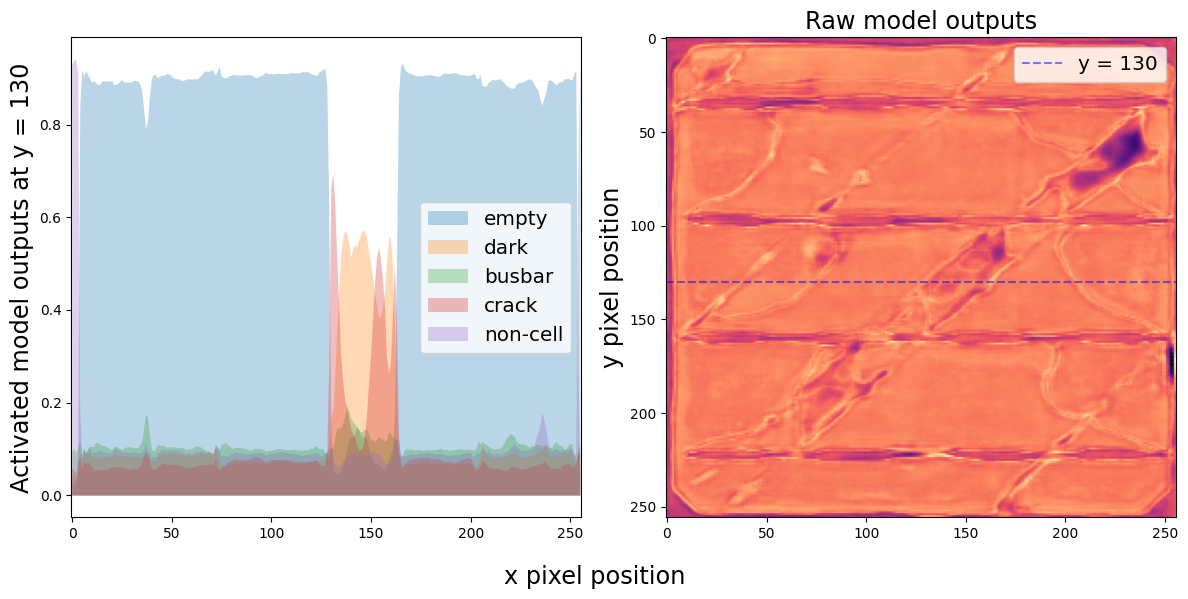

In [39]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/checkpoints/Fresh_Combined_CWRU_LBNL_ASU1/epoch_30/model.pt"


bu_name = "bu_1090.npy"
cr_name = "cr_1090.npy"
ann_dir = root + "ann/val/"
val_dataset = load_dataset(root, channeled=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
cr_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name))
)[0]
bu_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name))
)[0]

raw_model_outputs(63, root, weight_path, category_mapping)